In [1]:
import importlib

import dataset, metrics, plotting, config
from models import cgan_model
import numpy as np
import random

importlib.reload(dataset)
importlib.reload(metrics)
importlib.reload(plotting)
importlib.reload(config)
importlib.reload(cgan_model)

Using TensorFlow backend.
/Users/zhongsheng/anaconda2/envs/ganRegression/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/zhongsheng/anaconda2/envs/ganRegression/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/zhongsheng/anaconda2/envs/ganRegression/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16",

<module 'models.cgan_model' from '/Users/zhongsheng/Documents/GitWorkspace/ganRegression/models/cgan_model.py'>

In [2]:
import os

dataset_config = config.DatasetConfig(scenario="magical_sinus", n_instance=250)

assert(dataset_config.scenario == "linear"
       or dataset_config.scenario == "sinus"
       or dataset_config.scenario == "heteroscedastic"
       or dataset_config.scenario == "exp"
       or dataset_config.scenario == "multi-modal"
       or dataset_config.scenario == "magical_sinus"
      )
fig_dir = f"../figures/{dataset_config.scenario}"

try:
    os.mkdir(fig_dir)
    print(f"Directory {fig_dir} created")
except FileExistsError:
    print(f"Directory {fig_dir} already exists replacing files in this notebook")

Directory ../figures/magical_sinus already exists replacing files in this notebook


In [3]:
exp_config = config.Config(
    model=config.ModelConfig(activation="elu", lr_gen=0.0001, lr_disc=0.001, optim_gen="Adam",
                             optim_disc="Adam", z_input_size=5),
    training=config.TrainingConfig(n_epochs=2000, batch_size=100, n_samples=100),
    dataset=dataset_config,
    run=config.RunConfig(save_fig=1)
)

In [4]:
# Set random seed
np.random.seed(exp_config.model.random_seed)
random.seed(exp_config.model.random_seed)

from tensorflow import set_random_seed
set_random_seed(exp_config.model.random_seed)

In [5]:
X_train, y_train, X_test, y_test, _, _ = dataset.get_dataset(exp_config.dataset.n_instance,
                                                                         exp_config.dataset.scenario)

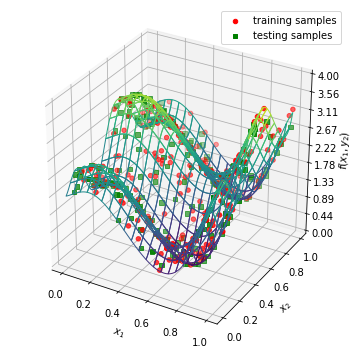

In [6]:
%matplotlib inline
plotting.plot_dataset(X_train, X_test, y_train, y_test, exp_config, fig_dir)


## Gaussian Process

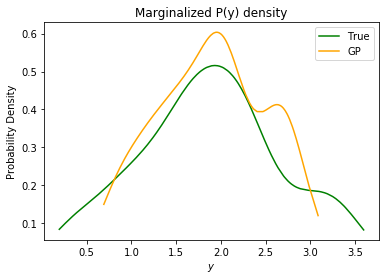

In [7]:
import GPy
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, RBF

noise = 5
length = 0.5

run_hyperopt_search = False

kernel = GPy.kern.RBF(input_dim=2, variance=noise, lengthscale=length)
gpr = GPy.models.GPRegression(X_train, y_train, kernel)

if run_hyperopt_search:
    gpr.optimize(messages=True)

ypred_gp_test, cov_test = gpr.predict(X_test)
plotting.plot_densities_joint(y_test, None, ypred_gp_test, "Marginalized P(y) density", fig_dir=fig_dir, prefix="all_marginalized")


## Construct CGAN model

In [ ]:
cgan = cgan_model.CGAN(exp_config)
d_loss_err, d_loss_true, d_loss_fake, g_loss_err, g_pred, g_true = cgan.train(X_train, y_train,
                                                                              epochs=exp_config.training.n_epochs,
                                                                              batch_size=exp_config.training.batch_size,
                                                                              verbose=False)

ypred_gan_test = cgan.predict(X_test)

In [ ]:
plotting.plots(d_loss_err, d_loss_true, d_loss_fake, g_loss_err, g_pred, g_true, fig_dir, exp_config.run.save_fig)

In [ ]:
ypred_mean_gan_test, ypred_median_gan_test, ypred_gan_sample_test = cgan.sample(X_test, exp_config.training.n_samples)

# Plots

## Mean Predictions

In [ ]:
plotting.plot_ypred_joint(X_test, y_test, ypred_mean_gan_test, None,
                          title="Linear-vs-GAN-vs-GP Mean Test Predictions", fig_dir=fig_dir, prefix="all_mean", legend=True,
                          elevation=10, azimuth=60, save_fig=exp_config.run.save_fig)

In [ ]:
# Single GAN sample
plotting.plot_ypred_joint(X_test, y_test, ypred_gan_test, None,
                          title="Linear-vs-GAN-vs-GP Mean Test Predictions", fig_dir=fig_dir, prefix="all_mean", legend=True,
                          elevation=15, azimuth=60, save_fig=exp_config.run.save_fig)


In [ ]:
plotting.plot_densities_joint(y_test, ypred_gan_sample_test, ypred_gp_test,
                              "Marginalized P(y) density", fig_dir=fig_dir, prefix="all_marginalized",
                              save_fig=exp_config.run.save_fig)

## GPy

In [ ]:
from plotting import _plot_surface

subplot

x_range = np.arange(0, 1, 0.01)
y_range = np.arange(0, 1, 0.01)
X, Y = np.meshgrid(x_range, y_range)
Z = function(X, Y)

norm = plt.Normalize(Z.min(), Z.max())
colors = cm.viridis(norm(Z))
surf = ax.plot_surface(X, Y, Z,
                           rstride=5, cstride=5, facecolors=colors, shade=False)

surf.set_facecolor((0, 0, 0, 0))




In [ ]:
import matplotlib.pyplot as plt
_, _, X_test_sample, y_test_sample, _, _ = dataset.get_dataset(exp_config.dataset.n_instance * 200,
                                                               exp_config.dataset.scenario)


fig, ax = plt.subplots(figsize =(5, 5))

x_plot = X_test_sample[:, 0]
y_plot = X_test_sample[:, 1]
ax.scatter(x_plot, y_plot)
plt.show()

In [ ]:

from dataset import get_true_x_give_y
from plotting import plot_scatter_density
from scipy import stats


bins = [0.5, 3.0, 2.22]
for Y in bins:
    X = get_true_x_give_y(Y, X=X_test_sample, y=y_test_sample)

    x = X[:, 0]
    y = X[:, 1]
    plot_scatter_density(x, y)



In [ ]:
import numpy as np
from dataset import _magical_sinus
import matplotlib.pyplot as plt

x = np.arange(0, 1, 0.01)
y = np.arange(0, 1, 0.01)
X, Y = np.meshgrid(x, y)
Z = _magical_sinus(X, Y)


fig, ax = plt.subplots()

counter = ax.contour(X, Y, Z, levels=[1.5], colors='b')
ax.clabel(counter, colors='k')
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
ax.set_aspect("equal", "box")
plt.show()

In [ ]:
import plotting
plotting.plot_contour(1)

In [ ]:
import plotting
plotting.plot_contour(1)

# Plots

## Mean Predictions

In [ ]:
plotting.plot_ypred_joint(X_test, y_test, ypred_mean_gan_test, None,
                          title="Linear-vs-GAN-vs-GP Mean Test Predictions", fig_dir=fig_dir, prefix="all_mean", legend=True,
                          elevation=10, azimuth=60, save_fig=exp_config.run.save_fig)

In [ ]:
# Single GAN sample
plotting.plot_ypred_joint(X_test, y_test, ypred_gan_test, None,
                          title="Linear-vs-GAN-vs-GP Mean Test Predictions", fig_dir=fig_dir, prefix="all_mean", legend=True,
                          elevation=15, azimuth=60, save_fig=exp_config.run.save_fig)


In [ ]:
plotting.plot_densities_joint(y_test, ypred_gan_sample_test, ypred_gp_test,
                              "Marginalized P(y) density", fig_dir=fig_dir, prefix="all_marginalized",
                              save_fig=exp_config.run.save_fig)

## GPy

In [ ]:
from plotting import _plot_surface

subplot

x_range = np.arange(0, 1, 0.01)
y_range = np.arange(0, 1, 0.01)
X, Y = np.meshgrid(x_range, y_range)
Z = function(X, Y)

norm = plt.Normalize(Z.min(), Z.max())
colors = cm.viridis(norm(Z))
surf = ax.plot_surface(X, Y, Z,
                           rstride=5, cstride=5, facecolors=colors, shade=False)

surf.set_facecolor((0, 0, 0, 0))




In [ ]:
import matplotlib.pyplot as plt
_, _, X_test_sample, y_test_sample, _, _ = dataset.get_dataset(exp_config.dataset.n_instance * 200,
                                                               exp_config.dataset.scenario)


fig, ax = plt.subplots(figsize =(5, 5))

x_plot = X_test_sample[:, 0]
y_plot = X_test_sample[:, 1]
ax.scatter(x_plot, y_plot)
plt.show()

In [ ]:

from dataset import get_true_x_give_y
from plotting import plot_scatter_density
from scipy import stats


bins = [0.5, 3.0, 2.22]
for Y in bins:
    X = get_true_x_give_y(Y, X=X_test_sample, y=y_test_sample)

    x = X[:, 0]
    y = X[:, 1]
    plot_scatter_density(x, y)



In [ ]:
import numpy as np
from dataset import _magical_sinus
import matplotlib.pyplot as plt

x = np.arange(0, 1, 0.01)
y = np.arange(0, 1, 0.01)
X, Y = np.meshgrid(x, y)
Z = _magical_sinus(X, Y)


fig, ax = plt.subplots()

counter = ax.contour(X, Y, Z, levels=[1.5], colors='b')
ax.clabel(counter, colors='k')
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
ax.set_aspect("equal", "box")
plt.show()

In [ ]:
import plotting
plotting.plot_contour(1)